# Implementing a Deep Neural Network from Scratch - Part 2
> In this series we build a Neural Network from the ground up, covering basic concepts along the way. In Part 2 we add a better loss function and transform our Linear Classifier into a real Deep Neural Network.

- toc: true
- badges: false
- comments: true
- categories: [machine-learning]
- image: images/nn-from-scratch-part-2.png
- sticky_rank: 2
- keywords: machine learning, ml, deep neural network, neural network, convolutional neural network, beginner concepts, fastai, fast.ai, pytorch, cross-entropy loss

In [78]:
#hide
!pip install -Uq fastbook
from fastbook import *

## Introduction

>Note: This post is the second post of a two-part series. If you landed on this page directly, I recommend following the whole journey and start by reading [Part 1](https://muttoni.github.io/blog/machine-learning/2020/12/28/Implementing-a-Deep-Neural-Network-from-Scratch-Part-1.html) first.


This is Part 2 of our "Implementing a Deep Neural Network from Scratch" series. In this part we will improve on our Linear classifier started in [Part 1](https://muttoni.github.io/blog/machine-learning/2020/12/28/Implementing-a-Deep-Neural-Network-from-Scratch-Part-1.html) and turn our Linear Model into a fully-functioning Deep Neural Network! 

As a reminder, our goal is to create a Neural Network that can distinguish all 10 handwritten digits (using the industry standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset). This is also known as a Multi-Label Classifier (a traditional Classifier only has two labels, such as cat or dog, hotdog or not hotdog, etc). In Part 1 we were able to train a simple linear regressor achieving roughly 80% accuracy after 50 epochs. We'll see in this part how to make it even more powerful with just a simple tweaks, as well as turn it into a Deep Neural Network.



##Getting Started

Below is a recap of all the preparatory steps to setup our data pipeline. In order: we download the data, generate a list of file paths, create training and validation tensor stacks from the file paths, convert those tensors from rank-2 (2D matrix) tensors (i.e. size: 28, 28) to rank-1 (1D vector) tensors (i.e. size: 784). 

In [79]:
#collapse

# Requirements
!pip install -Uq fastbook
from fastbook import *

# Download the data
path = untar_data(URLs.MNIST)

# Import the paths of our training and testing images
training = { f'{num}' : (path/f'training/{num}').ls().sorted() for num in range(10) }
testing = { f'{num}' : (path/f'testing/{num}').ls().sorted() for num in range(10) }

# Prepare training tensor stacks
training_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in training[f'{num}']
          ]) for num in range(10)
      ]

validation_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in testing[f'{num}']
          ]) for num in range(10)
      ]


# Convert our 2D image tensors (28, 28) into 1D vectors
train_x = torch.cat(training_tensors).view(-1, 28*28)
valid_x = torch.cat(validation_tensors).view(-1, 28*28)



Before generating our labels, we'll make a change in our labeling structure so as to be more efficient in space complexity as well as be more elegant and extendable for any number of labels in the future.

## Improving our Label Structure

Our labels in Part 1 were represented by a vector of size 10 with a '1' flag indicating the correct digit at the corresponding index, and '0' everywhere else. In our loss function, we then compared whether the max index of our predictions was equivalent to the index in our target labels where the index was '1'. Here's a quick example of how our old labels worked:

A target label $y$ for the digit '3':
```
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
          ^ a '1' flagging the correct digit at its index (3)
```

An example prediction from our model:
```
[2.0e-3, 1.3e-7, 4.0e-8, 9.9e-1, 2.0e-5, 1.6e-4, 4.4e-9, 7.0e-9, 1.3e-6, 2.1e-4, 4.0e-7]
                         ^ index of max value corresponds to the y label index, 
                           indicating a correct prediction.
```

There is, however, a much more efficient way of representing our labels. Can you guess what it is? If you guessed assigning a value to each of our digits (e.g. an integer corresponding to that digit) and just have that be our $y$ target label, then you guessed right! But in our loss function, how can we match/compare a prediction vector of 10 values to a target label, if the label contains only an integer (e.g. "3").

To answer this question we need to go back to our beloved **Softmax**. 

$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_j{e^{x_j}}}$

This is a great time to read [Part 1](https://muttoni.github.io/blog/machine-learning/2020/12/28/Implementing-a-Deep-Neural-Network-from-Scratch-Part-1.html) if you haven't already done so. Here's a quick reminder of how our Softmax works in three steps:
1. Given a list of values, we calculate the exponential for each value, that is: $e^{n}$. Where $n$ is our value and $e$ is Euler's number, a [special number in Mathematics](https://en.wikipedia.org/wiki/Eulers_number), and at the heart of the exponential function.
2. We sum the exponential values (the Sigma symbol $\sum$ means _sum_).
3. Take each value in Step 1. and divide it by the sum obtained in Step 2. 

The pecularity of Softmax is that when we softmax a list of values, since they are all divided by their sum, **all the values sum to 1**. This is incredibly useful as it means we only really need 1 value from the list, i.e. in our case the prediction corresponding to the correct label, as the rest of the values are just 1 - that value. If that value increases (i.e. the probability of our correct digit prediction increases), it also means that every other value in the prediction vector is consequently decreasing. This is why Softmax is a critical part of any multi-label classifier where only 1 label out of a group is correct (e.g. model of car), as it helps "hone in" on a single value, and work around that.

Practically, this means we can simplify our label structure and go from a vector of flags to a single integer representing the index of our possible labels. In the case of our MNIST dataset, the labels and indexes match, and will both go from 0 to 10. This means that if our $y$ variable is '0', our digit is '0', and we should look at the prediction value of our output vector at index '0'. The same goes for every other number. In cases were our $y$ is not a digit, we would still assign an integer to each possible label and proceed in exactly the same manner. 

In [80]:
# Generate our labels based on the digit each image represents
train_y = torch.from_numpy(np.concatenate([[i]*len(training[f'{i}']) for i in range(10)]))
valid_y = torch.from_numpy(np.concatenate([[i]*len(testing[f'{i}']) for i in range(10)]))

In our loss and accuracy functions, we'll also need to update the way we compare results. All it takes is a little code change (our loss function will change a little bit in the next section, for now just focus on the updated labeling mechanism).

In [ ]:
def loss_function(self, predictions, targets): 

  # softmax the vectors, each containing 10 probabilities
  sm_preds = self.softmax(predictions) 
  
  # generate a range equal to length of prediction batch
  idx = range(len(predictions))

  # from each vector, only pick the correct prediction 
  results = sm_preds[idx, targets]

  ...


 This nifty accessing technique, coupled with Softmax's characteristic of summing to one, means that with only need a single value from our predictions, not the whole vector, to calculate the prediction loss, as every other value in our prediction vector is completely co-dependent and therefore irrelevant.

We can now load our dataset and dataloaders as we did in Part 1:

In [81]:

# Create datasets to feed into the dataloaders
dset = list(zip(train_x, train_y))
dset_valid = list(zip(valid_x, valid_y))

# Setup our dataloders
dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=256, shuffle=True)

## Softmax Needs a Friend

Before we can proceed to improve and generalize our MNIST model from Part 1, we need to continue talking about Softmax. Yes, I know, by now you probably think I have a secret fetish for Softmax, and you're probably right. But Softmax needs a little TLC in order to function orders of magnitude better.

What the hell am I going on about? Well, Softmax is based on the exponential function $e^x$, which means that as our $x$ value increases, the exponential values increase...exponentially. The consequence of this is that a parameter that is slightly larger than the rest, when softmax'd, will tend to be exaggerated, squishing the rest. Here is an example (toggle to code block to see the softmax implementation):


In [4]:
#collapse
# Quick softmax implementation, expecting a list of values (rank-1 tensor)
def softmax(v):
  """
  Given an input vector v, returns an output vector containing
  the softmax values for each element in the vector
  """
  exp_v = torch.exp(v.float())
  exp_sum = exp_v.sum()
  return exp_v / exp_sum

In [5]:
# An softmax example with a list of values [1,2,4]
softmax(tensor([1,2,4]))

tensor([0.0420, 0.1142, 0.8438])

Notice how in the example above, the '4', when softmax'd, takes a larger-than-proportional share of the probability. As the difference gets larger, this becomes even more evident. This is great when making final predictions as we want the highest probability to shine through, but not when we want a nice stable loss function to help the model improve. As soon as a parameter is slightly larger than the rest, it will be hard for the others to compete and "catch up". We'll see how we can convert our naive loss function into an industry standard one, by _softening_ Softmax (ironic, isn't it?). We'll then compare performance and you'll see how a very small change will help get us better and more stable training accuracy in just a few epochs!

### Log: a Softmax's Best Friend

I've never liked logs, unless they are made of wood. But it seems logs (aka logarithms) are a crucial part of everyday life, as they help represent exponential values in linear form. I won't dive too deep into logarithms, as there are plenty of resources that will do a better job at explaining them. Feel free to look them up for a couple minutes before continuing this post just so you have a quick primer.

Since Softmax stems from the exponential function ($e^x$), by taking the log of the softmax'd values we are able to represent numers that are distanced exponentially in a more linear way. This is what I mean by "softening" Softmax, as rather than dealing with the raw values we are dealing with their exponents in base e. This helps stretch the values that were otherwise confined between 0 and 1, to a much larger range...what is the largest range imaginable? Infinity! Actually, for softmax it's 0 to -Infinity to be precise, and we'll see why in just a second.

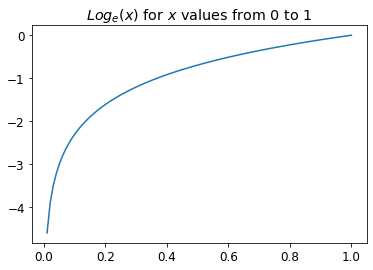

In [15]:
#hide_input
plot_function(torch.log, min=0, max=1, title="$Log_e(x)$ for $x$ values from 0 to 1")

>Tip: Our log function, in the context of Softmax, is always in base $e$, as our values are raised to the power of $e$. In Mathematics, logarithms involving $e$ (i.e. in _base_ $e$) are often referred to as $ln$. 


Our log function output (y-axis) can be intuitively thought of as: _"to the power of what must we raise $e$ in order to get $x$_. This is why log is not defined for $x < 0$ (remember: $e$ is positive, roughly equal to 2.718, so an exponent will never be able to change the sign of a positive number).

From the log plot above, we can see that $log_e(x)$ outputs values from -Infinity as $x$ approaches 0, and approaches 0 when $x$ approaches 1. Consequently, our Softmax values (that cumulatively sum to 1, and therefore always between 0 and 1) will **always be negative**. Let's take a look at our previous example with `[1,2,4]`, softmax them again and then take the log. Notice how the results are negative, and the relative ratios between them have softened.

In [7]:
torch.log(softmax(tensor([1,2,4])))

tensor([-3.1698, -2.1698, -0.1698])

We can multiply very value by -1 so as to deal with positive numbers, without changing the fact that the highest original number (4) is now the closest to 0...that is...closest to our minimum.

So we now have a function that squeezes original parameters into co-dependent probabilties (via softmax), then stretches them into a broader logarithmic range (via log) to help linearize the rate of growth, and _at the same time_ making it so that higher values turn into something that can be _minimized_ (approach zero). Now doesn't that sound perfect for a loss function? 


## Cross-Entropy Loss

What we've just seen above is a very popular loss function used in classification called **Cross-Entropy Loss**. It allows us to leverage the useful characteristics of softmax while retaining a relatively linear curve for parameter values so as to facilitate training. We'll see that by making this small change in our previous model, our training will be much more effective. 

For reference, here is our **old** code (feel free to toggle it).

In [ ]:
#collapse
class MNISTLinearClassifier:
  def __init__(self, train_dl, valid_dl, epochs, lr, verbose):
    self.lr = lr
    self.train_dl = train_dl
    self.valid_dl = valid_dl
    self.epochs = epochs
    self.weights, self.bias = self._init_params()
    self.softmax = nn.Softmax(dim=-1)
    self.accuracy_scores = []
    self.verbose = verbose

  def train(self):
    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        self._calc_grad(xb, yb)
        for p in [self.weights, self.bias]:
            p.data -= p.grad*self.lr
            p.grad.zero_()

      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self.softmax(self._linear_eq(image_tensor))
    _, prediction = probabilities.max(-1)
    # Return digit and vector of probabilities
    return prediction, probabilities

  def _calc_grad(self, xb, yb):
    preds = self._linear_eq(xb)
    loss = self._loss_function(preds, yb)
    loss.mean().backward()

  def _batch_accuracy(self, xb, yb):
    predictions = self.softmax(xb) 
    _, max_indices = xb.max(-1) # get the index of max value along 2nd dimension
    _, tag_indices = yb.max(-1) # get index of flag in our label tensors
    corrects = max_indices == tag_indices # check whether they match
    return corrects.float().mean() # calculate mean

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._linear_eq(xb), yb) for xb,yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    self._print(f'Epoch #{i}', score)

  def _linear_eq(self, x):
    return x@self.weights + self.bias

  def _loss_function(self, predictions, targets):
    predictions = self.softmax(predictions)
    return torch.where(targets==1, 1-predictions, predictions).mean(-1)

  def _print(self, *args):
    if self.verbose:
      print(*args)

  # Linear regression using SGD
  def _init_params(*args):
    return (torch.randn(28*28, 10)).requires_grad_(), (torch.randn(10)).requires_grad_()

Below is our **new**, updated code. We'll leverage the new label structure and implement a new loss function by performing all the steps discussed in the previous section: log our softmax values, and turn them positive. Everything else is pretty much identical (aside from our `_batch_accuracy` function that needed updating due our new labeling structure too). Feel free to diff it into diffchecker to see what changed.

In [24]:
#collapse_show
class MNISTLinearClassifier:
  def __init__(self, train_dl, valid_dl, epochs, lr, verbose):
    self.lr = lr
    self.train_dl = train_dl
    self.valid_dl = valid_dl
    self.epochs = epochs
    self.weights, self.bias = self._init_params()
    self.softmax = nn.Softmax(dim=-1)
    self.accuracy_scores = []
    self.verbose = verbose

  def train(self):
    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        self._calc_grad(xb, yb)
        for p in [self.weights, self.bias]:
            p.data -= p.grad*self.lr
            p.grad.zero_()

      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self.softmax(self._linear_eq(image_tensor))
    _, prediction = probabilities.max(-1)
    return prediction, probabilities

  def _calc_grad(self, xb, yb):
    preds = self._linear_eq(xb)
    loss = self._loss_function(preds, yb)
    loss.backward()

  def _batch_accuracy(self, xb, yb):
    predictions = self.softmax(xb)
    _, max_indices = xb.max(-1)
    corrects = max_indices == yb
    return corrects.float().mean()

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._linear_eq(xb), yb) for xb,yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    self._print(f'Epoch #{i}', score)

  def _linear_eq(self, x):
    return x@self.weights + self.bias

  def _loss_function(self, predictions, targets): # Cross-Entropy Loss
    log_sm_preds = torch.log(self.softmax(predictions))
    idx = range(len(predictions))
    loss = -log_sm_preds[idx, targets]
    return loss.mean()

  def _print(self, *args):
    if self.verbose:
      print(*args)

  def _init_params(*args):
    return (torch.randn(28*28, 10)).requires_grad_(), (torch.randn(10)).requires_grad_()

Now remember our old model took 50 epochs (on a good run) to reach 80% accuracy. If we try our new model now, it will consistently beat 80% accuracy within the first epoch! That's a considerable improvement thanks to a "log" and a negative sign. Goes to show how critical a proper loss function is in training a model effectively.

In [27]:
model = MNISTLinearClassifier(dl, valid_dl, 5, 0.5, True)

In [28]:
model.train()

Epoch #0 0.8151
Epoch #1 0.8507
Epoch #2 0.8656
Epoch #3 0.8777
Epoch #4 0.8789


It already beat our original model within the first epoch (81.5% accuracy vs 80% after 50 epochs) and reached ~88% accuracy within 5 epochs. That's awesome! We could try experimenting with various batch sizes and learning rates to see how accurate we can get our model within an arbitrary number of epochs, but this is beyond the scope of this post. Let's clean up our code further and turn it into a general Linear Classifier.

##Generalizing our Linear Model



Up until now, we wanted to build a MNIST classifier. Before we move on and "deepen" our neural network, let's clean up our code, modularize it and turn it into a general Linear Classifier that can be applied to any dataset, with any number of labels.

**Linear Model**

We'll start by generalizing our Linear equation into a standalone "LinearModel". It will simply initialize a tensor with a desired number of input and output parameters (weights and biases) with random values. The `model` method will carry out the actual linear equation, and the `parameters` method will return the weights and biases.

In [11]:
# General purpose Linear Model
class LinearModel:
  def __init__(self, inputs, outputs):
    self.input_size = inputs
    self.output_size = outputs
    self.weights, self.bias = self._init_params()

  def parameters(self):
    return self.weights, self.bias

  def model(self, x):
    return x@self.weights + self.bias

  def _init_params(self):
    weights = (torch.randn(self.input_size, self.output_size)).requires_grad_()
    bias = (torch.randn(self.output_size)).requires_grad_()
    return weights, bias


**Optimizer**

We'll then proceed to strip out our optimizer. Our optimizer will have a `step` method that will carry out the update for each parameter based on its gradient and an arbitrary learning rate `lr` (e.g. 0.01).

In [32]:
class SGD_Optimizer:
  def __init__(self, parameters, lr):
    self.parameters = list(parameters)
    self.lr = lr 
  
  def step(self):
    for p in self.parameters: p.data -= p.grad.data * self.lr
    for p in self.parameters: p.grad = None
    

Now let's rewrite our Classifier to use these two newly created classes, and run it again on the MNIST dataset to check that it works:

In [43]:
#collapse_show
class LinearClassifier:
  def __init__(self, input_shape, output_shape, train_dl, valid_dl, epochs, lr, optimizer, softmax, verbose):
    self.lr = lr
    self.train_dl = train_dl
    self.valid_dl = valid_dl
    self.epochs = epochs
    self.linear = LinearModel(input_shape, output_shape)
    self.optimizer = optimizer(self.linear.parameters(), self.lr)
    self.activation = nn.Softmax(dim=-1)
    self.accuracy_scores = []
    self.verbose = verbose

  def train(self):
    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        self._calc_grad(xb, yb)
        self.optimizer.step()

      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self.activation(self.linear.model(image_tensor))
    _, prediction = probabilities.max(-1)
    return prediction, probabilities

  def _calc_grad(self, xb, yb):
    preds = self.linear.model(xb)
    loss = self._loss_function(preds, yb)
    loss.backward()

  def _batch_accuracy(self, xb, yb):
    predictions = self.activation(xb)
    _, x_label = xb.max(-1)
    corrects = x_label == yb
    return corrects.float().mean()

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self.linear.model(xb), yb) for xb,yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    self._print(f'Epoch #{i}', score)

  def _loss_function(self, predictions, targets):
    log_sm_preds = torch.log(self.activation(predictions))
    idx = range(len(predictions))
    results = -log_sm_preds[idx, targets]
    return results.mean()

  def _print(self, *args):
    if self.verbose:
      print(*args)


In [44]:
train_dl = DataLoader(dset, batch_size=128, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=128, shuffle=True)

classifier = LinearClassifier(
    input_shape=28*28, 
    output_shape=10, 
    train_dl=train_dl, 
    valid_dl=valid_dl, 
    epochs=5, 
    lr=0.1, 
    optimizer=SGD_Optimizer,
    softmax=True,
    verbose=True)

In [45]:
classifier.train()

Epoch #0 0.7352
Epoch #1 0.8014
Epoch #2 0.8286
Epoch #3 0.8457
Epoch #4 0.8532


Like before, we could try experimenting with various batch sizes and learning rates -- here I used a `batch_size` of 128 and a learning rate `lr` of 0.1. The advantage of smaller batch sizes is that it allows the model to have more chances to perform gradient descent on the parameters before finishing an epoch, but the gradients may be less representative of the total dataset as they are based on fewer samples. The learning rate is also a critical aspect to experiment with as it determines how much of a step is done at every optimization run. If the learning rate is too big, we risk overshooting the minimum loss and potentially never reaching it, if the learning rate is too low, we won't make significant progress in training. Keep in mind you don't always need to guess, as some libraries offer a way to test different learning rates (e.g. fast.ai offers a [learning rate finder](https://fastai1.fast.ai/callbacks.lr_finder.html) in it's Learner class.)


## Activating our Network!

As mentioned at the conclusion of Part 1, what we've done up to now is create a linear classifier with a self-correcting capability through Stochastic Gradient Descent..._not_ a deep neural network. That is, because a neural network is non-linear, and it is composed of multiple layers. How do we break the linearity and add layers?

Is it by adding one or more linear models after the first one? Yes! These are called layers (and any intermediate layers before our output layer are called "hidden layers"). But adding more layers is not enough. If we were to add another linear model right after our first one, the weights and biases would still end up being...linear... as any sequence of linear equations can be summarized as a single linear equation with a set of parameters representing the average of the various layers. We need something more inbetween each linear classifier that breaks beyond the sad confines of a linear world: an **activation function**.


 

Before we tackle the activation function, let's recap what **activations** are. Activations are the calculated outputs from our linear equation(s). This means that in our Linear Model above, by creating 10 parameters for each pixel (remember our input weights are of shape (28\*28, 10), our linear equation will output 10 _activations_ per image. Since our Linear Classifier was comprised of only 1 layer of parameters, our 10 activations also correspond to the 10 desired _outputs_ of our model, i.e. when softmax'd each of the 10 items in the activation vector represent the probabilities for each digit [0-9] in our classification task. As we'll see in just a moment, the activations don't necessarily need to equal to our outputs, as there can be several _layers_ of linear models in a deep neural network (hence the name: "deep"). 

So one layer can output an arbitrary number of features (in practice the activations of that layer) and then feed those features into a second layer as inputs, that will output another set of features for the next layer, and so on, until the last layer where the activations correspond to our final output.

However, as we said earlier, if we were to add another linear model right after our first one, the weights and biases would still end up being...linear... as any sequence of linear equations can be summarized as a single linear equation with a set of parameters representing the average of the various layers. So how can we add more than 1 linear layers and break the inherent linearity? That's where the **activation function** comes into play.

### The Activation Function

The activation function acts as a filter through which input parameters are transformed from one layer to the next, so as to break the linear relationship. Any function that is not a linear equation technically acts as an non-linearity (e.g. a log function, an exponential function, etc). You can see a collection of activation functions [here](https://en.wikipedia.org/wiki/Activation_function). 

Among those, one function that works really well, is as simple as can be: the Rectifier function (also known as **Rectified Linear Unit**, or **ReLU**).

$f(x) = max(x, 0)$

That's it! The ReLU will simply replace any _negative_ input values with 0 (or you can read it as: _rectify_ any negative values _to_ 0). Other input values remain completely unchanged. In code, this is as simple as:

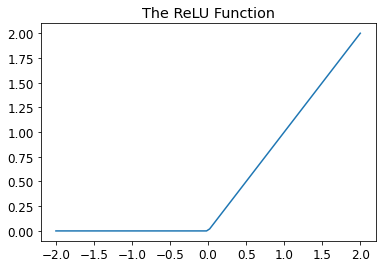

In [53]:
def ReLU(x):
  return x.max(tensor(0.))

plot_function(ReLU, title="The ReLU Function")

This simple transformation is enough to break linearity! Feel free to read more about the [ReLU function](https://en.wikipedia.org/wiki/Rectifier_\(neural_networks\)), but for our purposes this is all we need to continue.





## Implementing a Deep Neural Network




![](images/neural_network.png "A Neural Network, source: Wikipedia")

Equipped with our handy ReLU, we are ready to transform our Linear Model into a **real** Neural Network and allow for more than one linear layer! Now remember, a Neural Network is comprised of multiple linear layers (2 being the minimum not counting the activation function: one layer for the inputs, the activation, and the second layer for the outputs). Any number of layers can be added inbetween and are called **hidden layers**. There can be as many layers as we want, although the deeper the network, the more sophisticated it will be, meaning it will take longer to train, and the increased number of parameters can absorb a lot more peculiarities from each training image potentially over-fitting the data and not performing as well in validation, testing and production. We'll touch more on this further on in the post.

What we're going to be doing now, is effectively implement a very simple version of PyTorch's ``nn.Sequential``. In ``nn.Sequential``, we can specify $n$ layers and what activation function to use. The **activations** of any prior layer correspond to the **inputs** of the next layer. The last layer will always output the activations to be run through the **loss function**, exactly like in our LinearClassifier.

In [39]:

# Example 1
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # an input layer of 28*28 with 30 activations
    nn.ReLU(),           # the ReLU activation
    nn.Linear(30,10)     # another linear layer with 30 inputs and 10 activations
)

# Example 2
deeper_net = nn.Sequential(
    nn.Linear(28*28,100),# an input layer of 28*28 with 100 activations
    nn.ReLU(),           # the ReLU activation
    nn.Linear(100,30),   # a hidden layer of 100 inputs and 30 activations
    nn.ReLU(),           # the ReLU activation
    nn.Linear(30,10)     # another linear layer with 30 inputs and 10 activations
)

So how can we replicate something similar to the above? The good news is that we don't need to change a whole lot from our original LinearClassifier, except to introduce the concept of **layers** to our Classifier, as well as add the ReLU function. Other parts of the code (`SGD_Optimizer` and `LinearModel`) can be re-used as is!

### Layers


Taking inspiration from PyTorch's `nn.Sequential` mentioned above, we'll accept layers in a similar fashion, except we'll ReLU any input and hidden layers (everything but the last layer) automatically. That means we'll need to implement our DeepClassifier so as to be able to setup our model in the following way:

```python

# Example 1 (note: we still need to implement DeepClassifier)
simple_nn = DeepClassifier(
  LinearModel(28*28, 20), # We'll ReLU automatically after Layer 1.
  LinearModel(20, 10)     # LinearModel is the same one we used previously
)

# Example 2
deeper_nn = DeepClassifier(
  LinearModel(28*28, 40), # first layer, ReLU'd automatically
  LinearModel(40, 20),    # hidden layer, also ReLU'd automatically 
  LinearModel(20, 10)     # output layer
)
```

We'll begin by changing the name of our class from `LinearClassifier` to `DeepClassifier`. Finally! We'll also add a `self.layers` property in the `__init__` method that stores the incoming layers provided as a list of arguments when we setup the model. I'd also like to start logging/saving training loss to compare against our validation accuracy stored in `self.accuracy_scores` (remember it saves results from the `_validate_epoch` function that runs our weights against the validation data after each epoch). To do this we'll also add a `self.training_loss` list to save to.



In [ ]:
def __init__(self, *layers):
    self.accuracy_scores = []
    self.training_losses = []
    self.layers = layers # add a layers property

### Fit

We'll then change the terminology of our classifier so that instead of `train` we use `fit`. This is more consistent with other Deep Learning Libraries. In our `fit` method, we'll calculate how many layers `self.layers` has, and save the last layer's index (`self.last_layer_index`) so that we don't ReLU that layer later on. We'll also setup an optimizer for each layer that we can call `.step` from, using our previously defined `SGD_Optimizer` class. We'll also store the losses of each batch in an epoch to average out and compare against our validation accuracy.

In [ ]:
  def fit(self, **kwargs):
    self.train_dl = kwargs.get('train_dl')
    self.valid_dl = kwargs.get('valid_dl')
    self.epochs = kwargs.get('epochs', 5)
    self.lr = kwargs.get('lr', 0.1)
    self.verbose = kwargs.get('verbose', True)
    self.optimizers = []
    self.epoch_losses = [] # we'll average this after every epoch
    self.last_layer_index = len(self.layers)-1 # save last layer's index.

    for layer in self.layers:
      # for each layer, create an Optimizer we can .step() later on
      self.optimizers.append(SGD_Optimizer(layer.parameters(),self.lr))

    # our usual training loop
    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        # notice we use _forward now
        preds = self._forward(xb)
        self._backward(preds, yb)
  
      self._validate_epoch(i)

### Forward & Backward

We'll also introduce another structural change in the form of how our model operates. Rather than call `_calc_grad`, we'll instead group all of our linear calculations and activations in a `_forward` function, and all of our gradient calculations and optimizations in a `_backward` function. This makes more sense logically as we first calculate, then backtrack to get the gradients and update our parameters accordingly.

The `_forward` step loops through each layer in `self.layers` and calls each `LinearModel`'s `model` method (i.e. the famous linear equation `xb@w + b`). As long as the layer is not the last layer (`if layer_idx != self.last_layer_index:`), it will also rectify the outputs before passing them on to the next layer. 

In [ ]:
  def _forward(self, xb):
    res = xb
    for layer_idx, layer in enumerate(self.layers):
      if layer_idx != self.last_layer_index:
        res = layer.model(res)
        res = self._ReLU(res)
      else:
        res = layer.model(res)
    return res

The ReLU function is identicaly to the one created above. Pretty simple right?

In [ ]:
  def _ReLU(self, x):
    return x.max(tensor(0.0))

Our backward step `_backward` entails running our final outputs through the loss function and then calling `.backward()` to calculate the gradients of each tensor automatically. We'll also take note of the loss output so we can average each epoch's average loss in our `_validate_epoch` function. We'll then loop through all of our optimizers in `self.optimizers` and `step()` them so as to update the parameters according to our learning rate.

In [ ]:
  def _backward(self, preds, yb):
    loss = self._loss_function(preds, yb)
    # keep track of each batch's loss in a list
    self.epoch_losses.append(loss)
    loss.backward()
    for opt in self.optimizers: opt.step()

Our loss function also changes slightly, as we'll switch to using `torch.log_softmax` directly instead of torch.log followed by torch.softmax. This is because our previous implementation caused issues with gradients returning NaN across multiple layers. 

In [ ]:
  def _loss_function(self, predictions, targets):
    # we use torch.log_softmax directly
    log_sm_preds = torch.log_softmax(predictions, dim=1)
    idx = range(len(predictions))
    results = -log_sm_preds[idx, targets]
    return results.mean()

Finally, we can update our `_validate_epoch` function to condense the batch's losses into an average so we can compare each epoch's validation accuracy score vs the average training loss.

In [ ]:
  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._forward(xb), yb) for xb, yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    
    # stack all the saved losses from each batch and take the average
    epoch_loss = round(torch.stack(self.epoch_losses).mean().item(), 4)
    
    # clear the array for the next epoch of batches
    self.epoch_losses = []
    
    # append to the training_losses list
    self.training_losses.append(epoch_loss)
    self._print(f'Epoch #{i}', 'Loss:', epoch_loss, 'Accuracy:', score)

### Putting It All Together

And here is our DeepClassifier in all its glory! 

In [134]:
#collapse_show
class DeepClassifier:
  """
  A multi-layer Neural Network using ReLU activations and SGD
  params: layers to use (LinearModels)
  methods: fit(train_dl, valid_dl, epochs, lr)
  """
  def __init__(self, *layers):
    self.accuracy_scores = []
    self.training_losses = []
    self.layers = layers

  def fit(self, **kwargs):
    self.train_dl = kwargs.get('train_dl')
    self.valid_dl = kwargs.get('valid_dl')
    self.epochs = kwargs.get('epochs', 5)
    self.lr = kwargs.get('lr', 0.1)
    self.verbose = kwargs.get('verbose', True)
    self.optimizers = []
    self.epoch_losses = []
    self.last_layer_index = len(self.layers)-1

    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(),self.lr))

    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        preds = self._forward(xb)
        self._backward(preds, yb)
  
      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self._forward(image_tensor).softmax(dim=1)
    _, prediction = probabilities.max(-1)
    return prediction, probabilities

  def _forward(self, xb):
    res = xb
    for layer_idx, layer in enumerate(self.layers):
      if layer_idx != self.last_layer_index:
        res = layer.model(res)
        res = self._ReLU(res)
      else:
        res = layer.model(res)
    return res

  def _backward(self, preds, yb):
    loss = self._loss_function(preds, yb)
    self.epoch_losses.append(loss)
    loss.backward()
    for opt in self.optimizers: opt.step()

  def _batch_accuracy(self, xb, yb):
    predictions = xb.softmax(dim=1)
    _, max_indices = xb.max(-1)
    corrects = max_indices == yb 
    return corrects.float().mean() 

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._forward(xb), yb) for xb, yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    epoch_loss = round(torch.stack(self.epoch_losses).mean().item(), 4)
    self.epoch_losses = []
    self.training_losses.append(epoch_loss)
    self._print(f'Epoch #{i}', 'Loss:', epoch_loss, 'Accuracy:', score)

  def _loss_function(self, predictions, targets):
    log_sm_preds = torch.log_softmax(predictions, dim=1)
    idx = range(len(predictions))
    results = -log_sm_preds[idx, targets]
    return results.mean()

  def _ReLU(self, x):
    return x.max(tensor(0.0))

  def _print(self, *args):
    if self.verbose:
      print(*args)

The full code is available in this gist: https://gist.github.com/muttoni/d5ce076fdc83b8f82b9971c5c8bf6b2d

## Testing our Deep Classifier

Now that we've implemented our DeepClassifier, let's test its performance. Before we do, it's important to discuss the topic of complexity (i.e. depth and breadth). The deeper (more layers) and broader (more activations) we make our network, the more parameters and complexity our model will be able to learn, with the risk of potentially over-fitting our training data. The number of layers and parameters in a network should always be proportional to the amount of data and its complexity. There is no rule to apply, you just need to experiment and see. There's plenty of discussions around this topic so feel free to browse the web for people's rules of thumbs.

It's important to remember, that even the simplest (2 layer) neural network is able to theoretically approximate any function, and for most simple tasks is **more than enough**! You can try as an exercise to play around with layers and activation sizes to see how training is affected. Remember the accuracy scores outputed from all of the models created until now are always against **the validation data**, meaning that you may see accuracy decrease over time (a clear sign that the model is overfitting on the training data).

Anyways, enough talk, let's see it in action!

In [166]:
train_dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=256, shuffle=True)

my_nn = DeepClassifier(
  LinearModel(28*28, 20),
  LinearModel(20, 10)
)

In [167]:
#collapse_output
my_nn.fit(
    train_dl=train_dl, 
    valid_dl=valid_dl,
    lr=0.1,
    epochs=100
)

Epoch #0 Loss: 2.9898 Accuracy: 0.5713
Epoch #1 Loss: 1.2028 Accuracy: 0.6553
Epoch #2 Loss: 1.0008 Accuracy: 0.6754
Epoch #3 Loss: 0.8964 Accuracy: 0.7375
Epoch #4 Loss: 0.8207 Accuracy: 0.7498
Epoch #5 Loss: 0.756 Accuracy: 0.7441
Epoch #6 Loss: 0.7119 Accuracy: 0.7968
Epoch #7 Loss: 0.6837 Accuracy: 0.7902
Epoch #8 Loss: 0.642 Accuracy: 0.8166
Epoch #9 Loss: 0.6159 Accuracy: 0.7876
Epoch #10 Loss: 0.588 Accuracy: 0.8122
Epoch #11 Loss: 0.5736 Accuracy: 0.8244
Epoch #12 Loss: 0.5501 Accuracy: 0.835
Epoch #13 Loss: 0.5312 Accuracy: 0.8494
Epoch #14 Loss: 0.5108 Accuracy: 0.847
Epoch #15 Loss: 0.5047 Accuracy: 0.8305
Epoch #16 Loss: 0.4969 Accuracy: 0.8367
Epoch #17 Loss: 0.4766 Accuracy: 0.8019
Epoch #18 Loss: 0.4663 Accuracy: 0.8555
Epoch #19 Loss: 0.4654 Accuracy: 0.8535
Epoch #20 Loss: 0.4491 Accuracy: 0.8722
Epoch #21 Loss: 0.4398 Accuracy: 0.8579
Epoch #22 Loss: 0.4373 Accuracy: 0.8768
Epoch #23 Loss: 0.4362 Accuracy: 0.8375
Epoch #24 Loss: 0.4235 Accuracy: 0.8765
Epoch #25 Loss:

91%! (toggle the output to see the various training losses and accuracy scores over each epoch). Let's also test our beloved sample '5' prediction.

In [170]:
val_5 = (tensor(Image.open(testing['5'][0])).float()/255).view(-1, 28*28)
a = my_nn.predict(val_5)
a

(tensor([5]),
 tensor([[8.7256e-06, 6.7960e-08, 2.6373e-04, 1.8036e-02, 1.8940e-16, 9.4832e-01, 2.3715e-09, 6.1468e-06, 3.3328e-02, 4.1378e-05]], grad_fn=<SoftmaxBackward>))

It gives us a confidence of 95% that the digit is 5. Nice! Now let's discuss our results in more detail. 

### Analyzing Results 

Deep Neural Networks need to train longer as there are more parameters to tune. In our case, our 2-layer network after 100 epochs reached 91-92% accuracy with a learning rate of 0.1. Aside from the depth (layers) and breadth (parameters) of the model, learning rate also affects the number of epochs it takes as it "weighs down" the updating "power" of the optimizer so as to not overshoot the minimum loss.

By looking at the results above, we see how the training loss is still has room for improvement (remember, we're trying to get that as close to 0 as possible). When training a model it's important to consider over-fitting vs model accuracy. If your validation accuracy and training loss are both moving in the direction you want, it means you still have room to train! It doesn't make sense to continue training if instead you see the validation accuracy degrading consistently as that would be a clear sign of over-fitting on the training data.

To visualize all this better, let's create a quick function to visualize how our training loss and validation accuracy evolve over time (epochs).  

In [152]:
#collapse
def plot_results(my_nn):
  import matplotlib.pyplot as plt

  x = range(len(my_nn.accuracy_scores))
  y1 = my_nn.accuracy_scores
  y2 = my_nn.training_losses

  fig, ax1 = plt.subplots()

  ax2 = ax1.twinx()
  ax1.plot(x, y1, 'g-')
  ax2.plot(x, y2, 'b-')

  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Validation Accuracy', color='g')
  ax2.set_ylabel('Training Loss', color='b')
  plt.title(f"Results with lr={my_nn.lr}")
  plt.show()


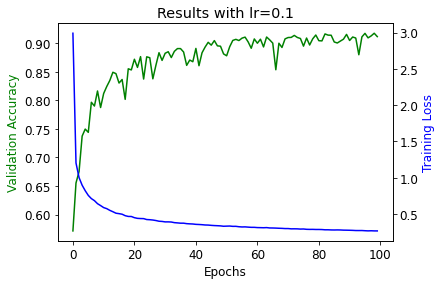

In [168]:
plot_results(my_nn)

The graph above shows how, over the course of 100 epochs, our training loss (in blue) and our validation accuracy (in green) have evolved. You'll see that our validation accuracy jumps around--that's because our model is only training on the training dataset, and our validation scores are measured on the validation dataset, so they don't get fed back into the model! This helps keep the model "honest", and gives us an idea of our our model will perform on unseen data.  As both our accuracy and loss are trending in the right direction, we could experiment extending the epoch count and tweaking the learning rate. 

###Learning Rates

Below are the same graphs with different learning rates, showing how they affect the model's performance over 100 epochs. As you can see, the higher the learning rate, the faster the accuracy improves, but it causes more jitter as the optimizing steps can overshoot across the loss function. The trick here is to pick one proportional to the amount of epochs you want to train (lower for more epochs, smaller for less epochs). Modern libraries (eg fast.ai) have convenient learning rate finders to take the guess work out.

Note that if you fit your model, and then try to fit it again, it will start from the previous weights, so you should probably pick a smaller learning rate the second time around as the "big" movements have already been done. 

![](images/2lyr-nn-results-trio.png)

Notice how the lower the learning rate, the smoother the training, but slower the ramp up and accuracy.

### Epochs

Now let's experiment by using a somewhat large 0.5 learning rate and training for 2.5x more epochs (250 total).

In [173]:
#collapse_output
my_nn = DeepClassifier(
  LinearModel(28*28, 20),
  LinearModel(20, 10)
)

my_nn.fit(
    train_dl=train_dl, 
    valid_dl=valid_dl,
    lr=0.5,
    epochs=250
)

Epoch #0 Loss: 1.7751 Accuracy: 0.6389
Epoch #1 Loss: 0.9891 Accuracy: 0.6981
Epoch #2 Loss: 0.7729 Accuracy: 0.7354
Epoch #3 Loss: 0.6788 Accuracy: 0.7412
Epoch #4 Loss: 0.613 Accuracy: 0.8305
Epoch #5 Loss: 0.5669 Accuracy: 0.7853
Epoch #6 Loss: 0.5323 Accuracy: 0.8262
Epoch #7 Loss: 0.4896 Accuracy: 0.8599
Epoch #8 Loss: 0.4714 Accuracy: 0.8681
Epoch #9 Loss: 0.4435 Accuracy: 0.873
Epoch #10 Loss: 0.4322 Accuracy: 0.8764
Epoch #11 Loss: 0.4081 Accuracy: 0.8563
Epoch #12 Loss: 0.3952 Accuracy: 0.8856
Epoch #13 Loss: 0.3825 Accuracy: 0.8837
Epoch #14 Loss: 0.3687 Accuracy: 0.8929
Epoch #15 Loss: 0.3569 Accuracy: 0.8975
Epoch #16 Loss: 0.344 Accuracy: 0.8987
Epoch #17 Loss: 0.3389 Accuracy: 0.9014
Epoch #18 Loss: 0.3296 Accuracy: 0.9057
Epoch #19 Loss: 0.3199 Accuracy: 0.9066
Epoch #20 Loss: 0.3178 Accuracy: 0.9041
Epoch #21 Loss: 0.3072 Accuracy: 0.8971
Epoch #22 Loss: 0.302 Accuracy: 0.899
Epoch #23 Loss: 0.3025 Accuracy: 0.9099
Epoch #24 Loss: 0.2941 Accuracy: 0.9134
Epoch #25 Loss:

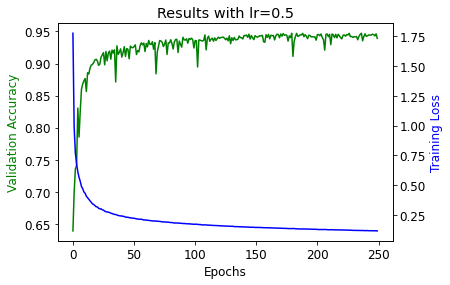

In [174]:
plot_results(my_nn)

While overall we achieved better accuracy (around 94%), we can start to see that after epoch ~175 the accuracy flattens out without significant improvement. This is a sign that now are model is just overfitting or that our learning rate is too coarse to fine-tune the model above ~94% accuracy. We'll see this issue a lot clearer if we plot the results again starting from epochs #100 onwards.

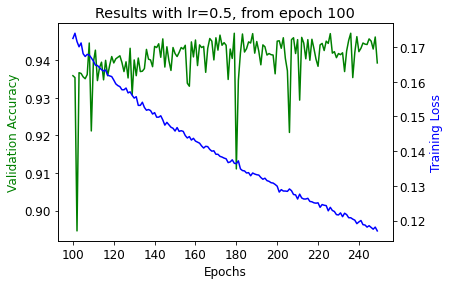

In [176]:
  #collapse_hide
  import matplotlib.pyplot as plt

  x = range(len(my_nn.accuracy_scores))
  y1 = my_nn.accuracy_scores
  y2 = my_nn.training_losses

  fig, ax1 = plt.subplots()

  ax2 = ax1.twinx()
  ax1.plot(x[100:], y1[100:], 'g-')
  ax2.plot(x[100:], y2[100:], 'b-')

  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Validation Accuracy', color='g')
  ax2.set_ylabel('Training Loss', color='b')
  plt.title(f"Results with lr={my_nn.lr}, from epoch 100")
  plt.show()

Lastly, let's also check what happens if we train with lower learning rates (0.005 and 0.01) and train for even longer (500 epochs). Given the large number of outputs I will omit the code snippets, but you get the hand of it by now!

![](images/2lyr-nn-results-lr005.png "lr=0.005, trained for 500 epochs")

In the case of `lr=0.005`, after 500 epochs final accuracy was around 88%, and the loss around 0.39 due to the low steps. The trends of both lines suggest it could do with more training. 

![](images/2lyr-nn-results-lr01l.png "lr=0.01, trained for 500 epochs")

For `lr=0.01`, we were able to achieve better accuracy (91%) but the loss function still hadn't completely plateaued (roughly around 0.30). Let's try again with a larger learning rate of 0.1 (10x bigger!)

![](images/2lyr-nn-results-lr10l.png "lr=0.1, trained for 500 epochs")

With `lr=0.01` were able to reach 93% accuracy and get the loss down to 0.18! but as you can see, the larger the learning rate, the rougher our learning curve (in terms of accuracy). This is because our parameters jump around much more. Let's choose a learning curve inbetween 0.01 and 0.1 (i.e. 0.05) and train for 1000 epochs!

![](images/2lyr-nn-results-lr05l.png "lr=0.05, trained for 1000 epochs")

With `lr=0.05`, after 1000 epochs we ended up with around 94.5% accuracy. However we already reached 94.5% accuracy back in epochs 700-800. When you train for an arbitrary number of epochs it could be that depending on your chosen configuration reaches an optimal accuracy somewhere in the middle of the training. This is why many frameworks implement an option called early stopping rounds whereby you can instruct the model to stop training when accuracy hasn't improved after $n$ rounds. From the image above it seems like there isn't much more room to grow and that curves are flat after epochs 750 or so, but if we zoom in on our graph, while rickety, there's still a clear trend on both metrics. 

![](images/2lyr-nn-results-lr05lz.png "lr=0.05, trained for 1000 epochs, showing epochs 600-1000")

Hopefully all these experiments show that machine learning is a craft of delicately balancing different constraints and making trade-offs, with only loose guidelines to guide our decision making! It is definitely not an exact science with strict, clear cut rules. There are so many parameters to take into consideration: batch sizes, learning rates, epochs, dataset size, layer count, parameter count. And that's not including other important decisions such as what type of loss function to use (spoiler alert, cross-entropy loss is only one of many!), what activation function to use, etc. This is is why machine learning is a field where there's plenty of room for experimentation and is full of unexplored territory.

## Conclusions

This marks the end of this series of building a Deep Neural Network from scratch. I realize these are two very long posts, but rather than split them up for the sake of splitting them up, I decided to condense everything into 2 parts so it's easier to keep track of links and follow along step by step. As linked above, the final `DeepClassifier` code is available [here](https://gist.github.com/muttoni/d5ce076fdc83b8f82b9971c5c8bf6b2d). Follow the steps in the series and experiment with all the possible parameter choices!

I really hope you enjoyed the series and learned something along the way. If you want to reach out, feel free to find my email in the "About" page or leave a comment below. With that, I'll close and wish you all the best in your machine learning journey!

### Aknowledgements 

This series could not have been possible without the incredible resource that the [fast.ai](http://course.fast.ai/) course is! I highly recommend you check it out as you will learn most of what's covered here and more! Most of what we covered in this series is part of Lessons 4 and 5 of the 2020 course. A big thank you to Jeremy and the fast.ai team for creating such a wonderful and inspiring course.